In [ ]:
import os
import requests
# import re
# from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive, files

# Монтируем гугл-диск

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Настройки
ВНИМАНИЕ! 
*   пропишите путь до вашей диретории;
*   укажите Ваш SERVICE_KEY для API vk.com;




In [ ]:
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/ЦП 2021'  # ВНИМАНИЕ! Пропишите путь до вашей диретории
CLASS_LIST = ['Путешествия', 'История', 'Наука и техника' 'Развлечения', 'Новости', 'Политика', 'Бизнес', 'Спорт', 'Личные данные']
SERVICE_KEY = ''  # ВНИМАНИЕ! Укажите Ваш SERVICE_KEY для API vk.com
VERSION = '5.122'

# Парсер vk
1. Используя api vk.com получим индентификатор пользователя, по которому спарсим все его публикации. 

2. Пройдём циклом по всем публикациям и склеим все текстовые поля в одно для дальнейшего создания "bag of words" ("мешка слов") для обучения нейросети.

3. В цикле возьмем 10 главных изображений публикации (если они есть) с разрешением от 200 до 400 пикселей по высоте. С большим количеством пикселей - нейросеть будет долго справляться и может быть ошибка из=за превышения лимита памяти. С меньшим разрешением - снизится качество распознавания, поэтому выберем изображения высотой от 200 до 400 пикселей из списка превьюшек в vk.com
Эти данные нужны будут для масштабирования проекта, когда пудем делать предсказания не только по тексту, но и по изображениям. На начальном этапе - только классификация по тексту.

4. Сформируем train датасет для нейронной сети.
Колонка 'text' - текст, 'img_0' ... 'img_9' - 10 ссылок на изображения, 'y' - индес класса

# Размечаем данные для обучения нейросети
Список блогеров, на которых мы будем обучать модель с разбитием по классам - отбираем и присваиваем классы вручную. На этих блогерах модель будет учиться. 

У нас жётское ограничение по времени, поэтому наш датасет будет очень скромным.

In [ ]:
blogers_list = [
  ['red21vr', 3],
  ['den_schmalz', 8],
  ['artur__babich', 3],
  ['aparfenchikov', 4],
  ['pokrovskaya_one', 3],
  ['mahavsekruto', 8],
  ['romanredder', 3],
  ['anriel', 8],
  ['naumova_maryana ', 8],
  ['id122880531', 8],
  ['ocoffi', 3],
  ['comedoz', 3],
  ['phosphxr', 3],
  ['ah_astahova', 3],
  ['arina_skoromnaya', 8],
  ['ramzan', 5],
  ['malafeev16ru', 7],
  ['yogris', 3],
  ['gusev_36', 4],
  ['zhora', 6],
  ['basta', 3],
  ['asmus__kristina', 8],
  ['vdemchog', 8],
  ['rodiongazmanov', 3],
  ['id18195959', 3],
  ['ladesov', 8],
  ['arbeninad', 3],
  ['gladkov_vv', 5],
  ['durov', 4],
  ['nosovdy', 5],
  ['kfnik', 7],
  ['id5178265', 8],
  ['vladimiruiba', 4],
  ['didenok', 8],
  ['andreybatt', 3],
  ['bahh_tee', 3],
  ['ivlevchef', 3],
  ['tapog', 3],
  ['timurrodriguez', 3],
  ['atl', 3],
  ['scinquisitor', 2],
  ['zheki444', 3],
  ['hovan', 3],
  ['romajigan', 8],
  ['serzhmorzh', 3],
  ['amirans', 8],
  ['aksenovrk', 4],
  ['artyukhov_da', 4],
  ['radiyhabirov', 4],
  ['aparfenchikov', 4],
  ['shumkov_vadim', 4],
  ['alexemelyanenko', 7],
  ['lybimovnikolay', 4],
  ['gubernator46', 4],
  ['a.tsybulskiy', 4],
  ['razvozhaev_m', 4],
  ['shapsha', 4],
  ['aleksandr__moor', 4],
  ['sergeylazarev', 3],
  ['nevzorovofficial', 5],
  ['sergeyvoropanov', 4],
  ['adam_moran', 3],
  ['tanya_rybakova', 8],
  ['hobo_halt', 0],
  ['meetthebrad', 0],
  ['jan', 0],
  ['id15963000', 0],
  ['drohn', 0],
  ['rai_naomi', 0],
  ['velecot', 7],
  ['id88384092', 0],
  ['aleksvena88', 0],
  ['id320436949', 0],
  ['ponomareva_iv', 8],
  ['levika3', 0],
  ['tatianka_92', 0],
  ['two6player', 0],
  ['id63220198', 0],
  ['rz1992', 0],
  ['first_loove', 0],
  ['id2800704', 0],
  ['captainxhardcore', 0],
  ['jilinanton', 7],
  ['little_chiffa', 8],
  ['roman178', 7],
  ['m_subbotina', 0],
  ['alex_karachevtsev', 0],
  ['klern', 0],
  ['iamshayahh', 0],
  ['oldi.guide', 0],
  ['id128100343', 0],
  ['astroman1792', 0],
  ['fink.anastasia', 0],
  ['petrosipov', 6],
  ['apras', 6],
  ['belpavser', 6],
  ['kupriyanov_dima', 6],
  ['di.marketer', 6],
  ['maximus', 6],
  ['eldar7', 6],
  ['ilya_kalyadin', 6],
  ['starokvashev', 6],
  ['talich', 2],
  ['kiselev.aleksey.samara', 7],
  ['slavabogomolov', 2],
  ['vasiliy_yandex_direct', 6],
  ['semagina_natalya', 6],
  ['dima.vasyukov', 0],
  ['kompaniets.andrey', 6],
  ['zorinws', 6],
  ['qwjbjx', 2],
  ['mr_malik', 6],
  ['luka_aleksey', 7],
  ['a.britva', 6],
  ['timafair', 6],
  ['dashkievm', 6],
  ['alexeydementev', 6],
  ['sergeysayanov', 6],
  ['psy_insight', 6],
  ['versilov', 7],
  ['shevaha_andriy', 6],
  ['id138630374', 6],
]

# Класс парсера Vk
Используем api vk для получения постов


In [ ]:
class User():
  def getId(self, user_ids):
    # Получаем id пользователя по user_ids
    data = {'access_token': SERVICE_KEY, 'v': VERSION, 'user_ids': user_ids}
    r = requests.get('https://api.vk.com/method/users.get', data)
    return r.json()['response'][0]['id']
  
  # Получаем все посты пользоватля
  def getWall(self, user_id):
    data = {'access_token': SERVICE_KEY, 'v': VERSION, 'owner_id': user_id}
    r = requests.get('https://api.vk.com/method/wall.get', data)
    r_json = r.json()
    if 'response' in r_json:  # Если профиль доступен
      return r_json['response']['items']
  
    return False  # Приватный профиль

  # Получаем список с текстом и url изображениями для датасета
  def getDataList(self, posts):
    text = ''
    img_count = 0;
    img_list = []  # Список изображений
    for post in posts:
      text += post['text'] + ' '  # Получаем текст всех записей
      if img_count < 10:  # Возьмём только 10 последних изображений
        if 'attachments' in post:
          if post['attachments'][0]['type'] == 'photo':
            sizes = post['attachments'][0]['photo']['sizes']  # Список изображений, размеры, url
            for size in sizes:  # Перебираем размеры изображений
              if size['height'] > 200 and size['height'] < 400:
                img_list.append(size['url'])
                img_count += 1

    # result_list = [text] + img_list
    result_list = [text]  # Пока только текст

    # Возвращаем только данные, если текст длинее 100 символов и длина result_list == 11 (количество изображений = 10)
    if len(result_list[0]) > 100: # Пока только текст - без and len(result_list) == 11:
      return result_list
    
    # Иначе данные считаем фальшивыми
    print(f'ПРОПУСКАЕМ, длина текста: {len(result_list[0])}')
    return False

# Перебираем список блогеров и создаём датасет, сохраняем

In [ ]:
user = User()
df_list = []  # Список для формирования датафрейма
for bloger in blogers_list:
  user_id = user.getId(bloger[0])
  posts = user.getWall(user_id)  # Получаем идентификатор пользователя, если введён никнейм

  print(f'user_id: {user_id}')

  if not posts:  # Пропускаем приватные профили и те из которых мы не можем получить информацию
    print('ПРОПУСКАЕМ')
    continue

  data_list = user.getDataList(posts)
  if data_list:
    bloger_list = data_list + [bloger[1]]
    df_list.append(bloger_list)

# df = pd.DataFrame(df_list, columns=['text', 'img_0', 'img_1', 'img_2', 'img_3', 'img_4', 'img_5', 'img_6', 'img_7', 'img_8', 'img_9', 'y'])
df = pd.DataFrame(df_list, columns=['text', 'y'])  # Пока только текст

df.to_csv(os.path.join(ROOT_PATH, 'vk_train_data.csv'), index=False)

user_id: 152108913
ПРОПУСКАЕМ, длина текста: 76
user_id: 177709874
user_id: 167759856
user_id: 419407976
user_id: 47903500
user_id: 99553591
user_id: 126109056
user_id: 83132571
user_id: 104916144
user_id: 122880531
user_id: 53260546
user_id: 7708047
user_id: 87971053
user_id: 1399678
user_id: 942327
user_id: 279938622
user_id: 274999264
user_id: 2099349
user_id: 572534614
user_id: 3420
user_id: 2128351
user_id: 173725684
user_id: 210963617
user_id: 3250683
user_id: 18195959
user_id: 385429433
user_id: 290697449
user_id: 639631882
user_id: 1
user_id: 152817444
user_id: 3601537
user_id: 5178265
user_id: 597516834
user_id: 3471320
user_id: 1361100
user_id: 770759
user_id: 454339300
user_id: 4545435
user_id: 40434887
ПРОПУСКАЕМ, длина текста: 20
user_id: 9879430
user_id: 187756
user_id: 120685155
user_id: 1770436
user_id: 2080539
user_id: 21071117
ПРОПУСКАЕМ, длина текста: 20
user_id: 8658426
user_id: 535871340
user_id: 517493162
user_id: 413272232
user_id: 419407976
user_id: 510423964
us

# Посмотрим датафрейм

In [ ]:
print(f'Форма датасета:{df.shape}')
print('Посмотрим структуру датасета:\n', df.head())

Форма датасета:(105, 2)
Посмотрим структуру датасета:
                                                 text  y
0   В сумке у папы Моя татуха      Мой личный рей...  8
1  Ребятки, мы вместе Cheetos, Аней и Махой запус...  3
2  Онлайн-совещание по итогам работы в Беломорско...  4
3    Встретимся сегодня! Выкладывай свои записи с...  3
4  Ээээй бро!\nБудущего не знаем, но чтобы не был...  8


# Гистограма длинны текста блогеров

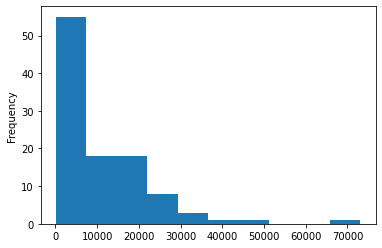

In [ ]:
text_len = df['text'].apply(len)
text_len.plot.hist()